[Jean-Nicholas Hould](http://www.jeannicholashould.com/)

In [1]:
%load_ext watermark

In [2]:
%watermark -u -v -d -p pandas,seaborn,pandas_profiling

last updated: 2017-04-22 

CPython 3.6.0
IPython 5.1.0

pandas 0.19.2
seaborn 0.7.1
pandas_profiling n


/Users/jhould/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<small>[More information](https://github.com/rasbt/watermark) about the `watermark` magic command extension.</small>

In [3]:
%matplotlib inline

# Exploratory Data Analysis of Craft Beers: Data Profiling

Exploratory data analysis (*EDA*) is a statistical approach that aims at discovering and summarizing a dataset. At this step of the data science process, you want to explore the structure of your dataset, the variables and their relationships.

In this post, we'll focus on one aspect of exploratory data analysis: data profiling. Data profiling is all about summarizing your dataset through descriptive statistics. You want to use a plethora of measurements to better understand your dataset. Data types, missing values, mean, median and standard deviation are just a few of the many elements you'll need to gather when profiling a dataset. The goal of data profiling is to have a solid understanding of your data so you can afterwards start querying and visualizing your data in various ways.


## Know Where Your Data Comes From

Before jumping in any EDA, you should know as much as possible on the provenance of the data you are analyzing. You need to understand how the data was collected and how it was processed. Are there any past transformations on the data that could affect your analysis? You should be able to answer those questions on your dataset:

- How was it collected?
- Is it a [sample](https://en.wikipedia.org/wiki/Sample_(statistics)?
- Was it properly sampled? 
- Was the dataset transformed in any way?
- Are there some know problems on the dataset? 

If you don't understand where the data is coming from, you will have a hard time drawing any meaningful conclusions from the dataset. You are also at risk of making very important analysis mistakes.

Additionally, you should make sure the dataset is structured in a standardized manner. The recommended format is the third normal form, also named [tidy data](http://vita.had.co.nz/papers/tidy-data.pdf). A "tidy" dataset has the following attributes:

- Each variable forms a column and contains values
- Each observation forms a row
- Each type of observational unit forms a table

Respecting this standardized format will speed up your analysis since this it's compatible with many tools and libraries. 

## Data Profiling

In this post, you will use a dataset of Craft Beers from the CraftCans website. This dataset only contains data from **canned** beers from breweries in the **United States**. It's not clear from the website if this dataset reports every single canned beer brewed in the US or not. To be safe, we will consider this dataset to be a sample that may contain biases.

Here is the structure of the datasets you'll be using:

**Beers:**

- `ID`: Unique identifier of the beer.
- `Name`: Name of the beer.
- `ABV`: Alcohol by volume of the beer.
- `IBU`: International Bittering Units of the beer.
- `Style`: Style of the beer.
- `Ounces`: Ounces of beer.

**Breweries:**

- `ID`: Unique identifier of the brewery.
- `Name`: Name of the brewery.
- `City`: City where the brewery is located.
- `State`: State where the brewery is located.

    

### Data Types 

The first step is to understand the composition of your dataset. What variables are you dealing with? You can generally fit the data in one of those categories:

- Numerical
- Categorical 
- Text
- Date 


In [4]:
import pandas as pd
import pandas_profiling
import seaborn as sns
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

We'll first import the datasets. We'll also join the `beers` and `breweries` datasets together to facilitate analysis down the road.

In [6]:
beers = pd.DataFrame.from_csv("../data/processed/beers.csv")
breweries = pd.DataFrame.from_csv("../data/processed/breweries.csv")
beers_and_breweries = pd.merge(beers, 
                               breweries, 
                               how='inner', 
                               left_on="brewery_id", 
                               right_on="id", 
                               sort=True,
                               suffixes=('_beer', '_brewery'))

With the pandas library, you can run the function `dtypes` to list each column and their data types. 

In [7]:
beers.dtypes

abv           float64
ibu           float64
id              int64
name           object
style          object
brewery_id      int64
ounces        float64
dtype: object

As you can see above, that function doesn't do a clean grouping of the different data types. The various numerical data types (`float64` and `int64`) are not grouped into a single category as we would like to. Also, some columns are listed as objects which is not very helpful.

To go around this, you can build your own function that will determine the category of each column in a `DataFrame`.

In [8]:
def get_var_category(series):
    unique_count = series.nunique(dropna=False)
    total_count = len(series)
    if pd.api.types.is_numeric_dtype(series):
        return 'Numerical'
    elif pd.api.types.is_datetime64_dtype(series):
        return 'Date'
    elif unique_count==total_count:
        return 'Text (Unique)'
    else:
        return 'Categorical'

def print_categories(df):
    for column_name in df.columns:
        print(column_name, ": ", get_var_category(df[column_name]))

#### `Beers` Variables

In [9]:
print_categories(beers)

abv :  Numerical
ibu :  Numerical
id :  Numerical
name :  Categorical
style :  Categorical
brewery_id :  Numerical
ounces :  Numerical


#### `Breweries` Variables

In [10]:
print_categories(breweries)

name :  Categorical
city :  Categorical
state :  Categorical
id :  Numerical


With this information, we can already better understand our dataset. We know we are dealing only with categorical and numerical data. Numerical variables can be used to extract many different measurements such as the mean, standard deviation, etc. Categorical variables are generally an interesting way of segmenting and grouping the data. For example, we might want to understand how the `IBU` differs between the various styles of beers.

### Descriptive Statistics

In this section, we'll walk through various descriptive statistics that can be used to better understand our data. You'll notice that each of those measurements in isolation is not very helpful.  The combination of those different measurement is where you can extract the most value. 

We will focus on the `IBU` variable because it is a numerical variable. This type of variable offers a broader range of measurements than the categorical variables. You can still run measurements on your categorical variables but you will be much more limited.

#### Length

The `len` function counts the number of observations in a `Series`. The function will count all observations, regardless if there are missing or null 
values.

In [11]:
length = len(beers["ibu"])
length

2410

In this `Series` we have a total of 2410 observations.

#### Count

The `count` function will return the number of non-NA/non-null observations in a `Series`.

In [12]:
count = beers["ibu"].count()
print(count)

1405


We have 1405 non-null observations in the `Series`.

#### Missing Values

With the `Length` and the `Count`, we are now able to calculate the number of missing values. The number of missing values is the difference between the `Length` and the `Count`.

In [13]:
number_of_missing_values = length - count
pct_of_missing_values = float(number_of_missing_values / length)
pct_of_missing_values = "{0:.1f}%".format(pct_of_missing_values*100)
print(pct_of_missing_values)

41.7%


To output the missing values as a percentage, we simply divide the number of missing values by the total number of observations, the length. The `float` function is used to make sure the decimals are captured in the division. The `format` function is used to nicely format the number as a percentage.


In this case, we are missing almost 42% of the `IBU` variable. This is important for us to know because it will affect our analysis. Most of the descriptive statistics will ignore those missing values and this will certainly cause a bias.

#### Minimum/Maximum Value

The minimum and maximum value of a dataset can easily be obtained with the `min` and `max` function on a `Series`.

In [14]:
print("Minimum value: ", beers["ibu"].min())
print("Maximum value: ", beers["ibu"].max())

Minimum value:  4.0
Maximum value:  138.0


The min/max values are helpful to understand the range of values in a variable. In this case, the `IBU` ranges from 4 to 138. 

#### Mode

The mode is the most frequent value in a dataset. It can be obtained using the `mode` function on a `Series`.

In [15]:
print(beers["ibu"].mode())

0    20.0
dtype: float64


In a normal distribution, the mode is equal to the `mean` and `median`.  

In this case, the mode of the `IBU` variable is `20`. It is the most frequent `IBU` in our dataset.

#### Mean

The mean is a measure of central tendency. It represents the sum of the values divided by the count of non-missing observations. 

It can be obtained with the `mean` function on a `Series`.

In [16]:
beers["ibu"].mean()

42.71316725978647

The mean is prone to be influenced by outliers. A few extreme values can greatly change the mean, dragging it up or down.

#### Median

The median is also a measure of central tendency. It is the number exactly in the middle of an ordered list of numerical values.

In [17]:
beers["ibu"].median()

35.0

In the case of skewed distributions, the median is a much better measure of central tendency than the mean.

In the case of the `IBU` distribution, the mean and the median are in the same orders of magnitude.

#### Standard Deviation

The standard deviation is a measure of dispersion. A high standard deviation indicates the data points are spread over a wide range of values. The standard deviation is expressed in the same unit as the values.

In [18]:
beers["ibu"].std()

25.954065911259324

In this case, the standard deviation is ~26. If the distribution of `IBU` was a normal distribution, we would know that ~68% of the observations are within one standard deviation of the mean.

#### Quantile Statistics

Quantiles are cut points that split a distribution in equal sizes. Many quantiles have their own name. If you split a distribution into four equal groups, the quantile you created is named `quartile`. You can easily create quantile using the `quantile` function on a `Series`. You can pass to that function an array with the different quantiles to compute. In the case below, we want to split our distribution in four equal groups.

In [19]:
beers["ibu"].quantile([.25, .5, .75])

0.25    21.0
0.50    35.0
0.75    64.0
Name: ibu, dtype: float64

As you can see above, the 50% quantile is equal to the median. It is the value that splits the dataset in half. We can also note that 75% of the observations are equal or below to 64 `IBU`. Furthermore, 50% of the distribution is located between 21 and 64 `IBU`. It's important to note that the missing values are not taken into account in those metrics. 

#### Distribution Plots

Visualizations are very useful in exploratory data analysis. In this post, we will not go over the topic visualizations. However, we can't talk about data profiling without mentioning the importance of a frenquency-distribution plot. It is one of the simplest yet most powerful visualization. It demonstrates the frequency of each value in our dataset.

To create this visualization, we are using the `seaborn`` library with the `displot` function. This function expects a `Series` with no missing values.

/Users/jhould/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


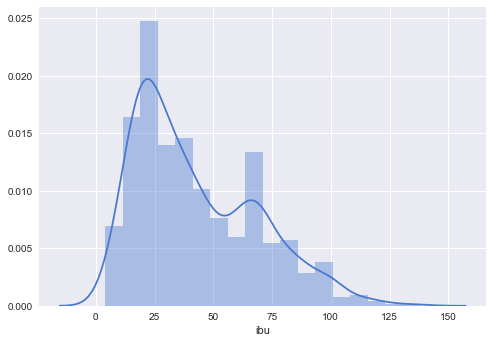

In [20]:
sns.distplot(beers["ibu"].dropna());

In this distribution plot, you can clearly see a few of the values we previously calculated. The minimal value is close to 0 `IBU` and the maximum value is close to 140 `IBU`. We clearly see that the most frequent value is close to 20 `IBU`. Additionally to this information, we now see a peak close to 60 `IBU`. Why are there two peaks in this distribution? What can explain this? This is an aspect that we can explore in the second phase of exploratory data analysis.

#### Correlations

Correlations are a great way to discover relationships between numerical variables. There are various ways to calculate the correlation. The Pearson correlation coefficient is a widely used approach that measures the linear dependence between two variables. The correlation coefficient ranges from -1 to 1. A correlation of 1 is a total positive correlation, a correlation of -1 is a total negative correlation and a correlation of 0 is non-linear correlation. We can perform that calculation using the `corr` function on a `Series`. By default, this function will use the Pearson correlation coefficient calculation. It is possible to use different methods of calculation with this function.

In [21]:
beers[["abv", "ibu", "ounces"]].corr()

,abv,ibu,ounces
abv,1.000000,0.670621,0.172529
ibu,0.670621,1.000000,0.054691
ounces,0.172529,0.054691,1.000000


As you can see above, the correlation between `IBU` and itself is 1. Obviously, numerical variables are perfectly correlated with themselves. More interestingly, you can see that the correlation of the `ABV` and `IBU` is equal to  `0.670621`. While this is not a total positive correlation, it is still highly correlated. This is an interesting aspect that we can explore further down the road.

#### A few notes on non-numerical variables

The metrics that have been previously extracted are mostly applicable for numerical values only. If you are dealing with other types of data such as categorical data, you can still gather some interesting measurements. You could calculate the frequency of each value in the dataset.

`DataFrame` have a function named `describe` that summarizes the dataset. If your `DataFrame` only has categorical or text values, the summary will be adapted specifically for this type of data.

In [22]:
beers[["name", "style"]].describe()

,name,style
count,2410,2405
unique,2305,99
top,Nonstop Hef Hop,American IPA
freq,12,424


### Profiling Libraries

As you've seen above, gathering descriptive statistics can be a tedious process. Gladly, there are libraries that exist that perform all of the data crunching for you. They output a very clear profile of your data. `pandas-profiling` is one of them.  That library offers out-of-the-box statistical profiling of your dataset. Since the dataset we are using is tidy and standardized, we can use the library right away on our dataset.

In [28]:
pandas_profiling.ProfileReport(beers_and_breweries).to_file(outputfile="./pandas_profilin_report.html")

### More Questions

Generally, once you have profiled your dataset, you have a lot more question on it than you initially had. This is great because those new questions will fuel your exploratory data analysis.

Here are a few questions that we have gathered while doing this profiling:

- 41.7% of the `IBU` values are missing. Why is that? How can that affect our analysis? 
- There are two peaks in the `IBU` distribution. What explains this? 
- What explains the correlation between `IBU` and `ABV`? What is the influence of the beer style in this correlation?
- Are there differences in the `IBU`, `ABV` or `Style` between geographical regions? What about the East Coast vs the West Coast?

Data profiling is not a linear process.  As you filter and segment your dataset, you will come back to it and gather descriptive statistics on subgroups of your data.

## Next Steps

In this post, you have seen how to profile a dataset. You now know how to attribute variables to specific data types groups. You have also calculated different descriptive statistics on the dataset and you understand how to interpret those measurements. Finally, you have seen that there are some libraries that can help you do the crunching to profile your dataset. More importantly, you have generated more questions than ever to fuel your exploratory data analysis.